# 1: Import and preparation

In [51]:
import pandas as pd

# Load the datasets
true_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")

# Add labels to the data (1 for true news, 0 for fake news)
true_news["label"] = 1
fake_news["label"] = 0

# Combine the datasets
data = pd.concat([true_news, fake_news], ignore_index=True)

# Preprocess and clean the text data
# You can use libraries like NLTK or spaCy for text preprocessing
data.drop(columns = ['date'], inplace = True)
data.drop(columns = ['text'], inplace = True)
#data['title+text'] = data['title'] + ' ' + data['text']
data.head()

,title,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,1
1,U.S. military to accept transgender recruits o...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,politicsNews,1


# 2: Data Cleaning

In [52]:
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
nltk.download("stopwords")
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edu', 'reuters'])

# Removing Stopwords And Remove Words With 2 Or Less Characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

data['cleaned'] = data['title'].apply(preprocess)

[nltk_data] Downloading package stopwords to /Users/kjeks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
list_of_words = []
for i in data.cleaned:
    for j in i:
        list_of_words.append(j)
total_words = len(list(set(list_of_words)))
data['clean_joined'] = data['cleaned'].apply(lambda x: " ".join(x))
data

,title,subject,label,cleaned,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,1,"[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,politicsNews,1,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,1,"[senior, republican, senator, mueller]",senior republican senator mueller
3,FBI Russia probe helped by Australian diplomat...,politicsNews,1,"[russia, probe, helped, australian, diplomat]",russia probe helped australian diplomat
4,Trump wants Postal Service to charge 'much mor...,politicsNews,1,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,Middle-east,0,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailors
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,Middle-east,0,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Middle-east,0,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,Middle-east,0,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls quits


# 3: Visualization

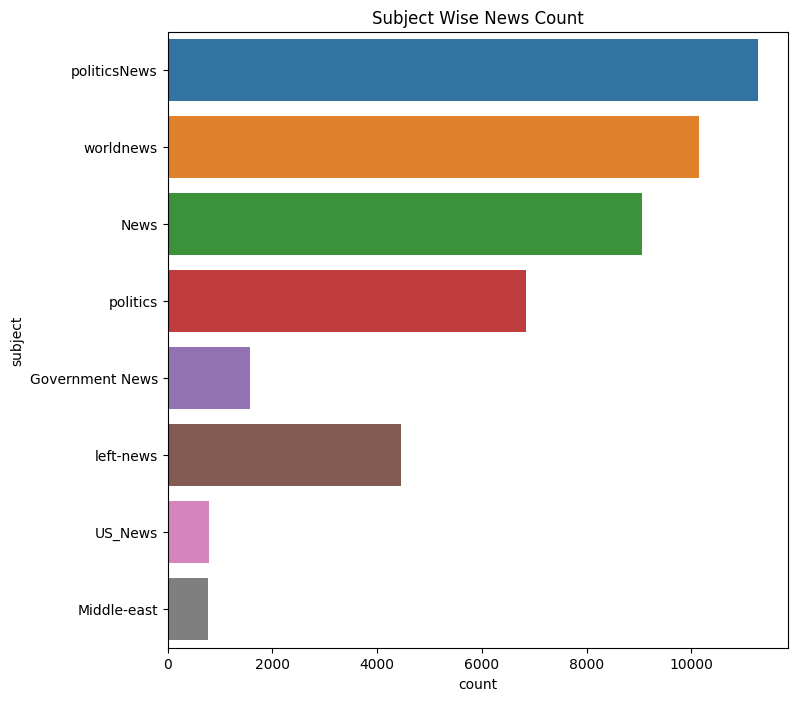

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 8))
plt.title("Subject Wise News Count")
sns.countplot(y = "subject", data = data)
plt.show()

# 4: Tokenization And Padding

In [55]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train, x_test, y_train, y_test = train_test_split(data.clean_joined, data.label, test_size = 0.2)

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

# 5: Building And Training The Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
import numpy as np

model = Sequential()

# Embeddidng layer
model.add(Embedding(total_words, output_dim = 128))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

y_train = np.asarray(y_train)
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 5)

Epoch 1/5
506/506 [==============================] - 34s 60ms/step - loss: 0.1957 - acc: 0.9165 - val_loss: 0.1372 - val_acc: 0.9435
Epoch 2/5
506/506 [==============================] - 23s 46ms/step - loss: 0.0687 - acc: 0.9747 - val_loss: 0.1455 - val_acc: 0.9465
Epoch 3/5
506/506 [==============================] - 23s 45ms/step - loss: 0.0339 - acc: 0.9888 - val_loss: 0.1738 - val_acc: 0.9362
Epoch 4/5
506/506 [==============================] - 24s 47ms/step - loss: 0.0216 - acc: 0.9926 - val_loss: 0.2212 - val_acc: 0.9362
Epoch 5/5
506/506 [==============================] - 22s 43ms/step - loss: 0.0138 - acc: 0.9955 - val_loss: 0.2367 - val_acc: 0.9357


In [57]:
pred = model.predict(padded_test)

prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.95:
        prediction.append(1)
    else:
        prediction.append(0)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)

281/281 [==============================] - 3s 9ms/step
Model Accuracy :  0.5242761692650334


# 6: Finding topics that indicate fake news (unfinished)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(data['clean_joined']).toarray()
y = data["label"].values

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and test sets (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets (75/25)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Define a list of possible C values to try
C_values = np.logspace(-3, 3, 7)

# Initialize the best accuracy and best C value
best_accuracy = 0
best_C = None

for C in C_values:
    model = LogisticRegression(max_iter=1000, C=C)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_C = C

    print(f"C: {C}, Validation accuracy: {val_accuracy}")

print(f"Best C: {best_C}, Best validation accuracy: {best_accuracy}")

# Train the model with the best hyperparameters
best_model = LogisticRegression(max_iter=1000, C=best_C)
best_model.fit(X_trainval, y_trainval)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


C: 0.001, Validation accuracy: 0.5376391982182628
C: 0.01, Validation accuracy: 0.8821826280623608
C: 0.1, Validation accuracy: 0.9133630289532294
C: 1.0, Validation accuracy: 0.9301781737193764
C: 10.0, Validation accuracy: 0.9319599109131403
C: 100.0, Validation accuracy: 0.9229398663697105
C: 1000.0, Validation accuracy: 0.9121380846325167
Best C: 10.0, Best validation accuracy: 0.9319599109131403
Test accuracy: 0.9416481069042316


In [60]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Investigate feature importance
feature_importance = pd.DataFrame({"feature": vectorizer.get_feature_names_out(), "importance": model.coef_[0]})
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("Top features for fake news:")
print(feature_importance.head(10))

print("Top features for true news:")
print(feature_importance.tail(10))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4650
           1       0.92      0.90      0.91      4330

    accuracy                           0.91      8980
   macro avg       0.92      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980

Top features for fake news:
          feature  importance
2910      myanmar   59.544105
2676     malaysia   42.362283
4668      turkish   41.976855
1584      factbox   39.088349
1504         euro   36.990675
2542  legislature   34.128259
3480       pursue   33.679752
1483        envoy   33.357512
3568      readies   32.847189
534        brazil   32.414312
Top features for true news:
       feature  importance
504       boom  -39.980633
3875     saved  -40.174444
1191      dems  -40.415969
1228   destroy  -40.440540
538   breaking  -44.059638
4270     stein  -45.035978
2156  illegals  -46.477883
527      brags  -46.693376
2518   leaking  -54.714373
4779     video  -

In [61]:
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
